In [ ]:
!pip install -U sentence-transformers

In [ ]:
import torch
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pairs_df = pd.read_excel('/content/drive/MyDrive/DS 677 - Sentence Transformer/Output Files/fused_matches (image_text first).xlsx')
model = SentenceTransformer('/content/drive/MyDrive/DS 677 - Sentence Transformer/Output Files/model_mnr')

In [ ]:
# Encode text

ulta_texts = pairs_df['Ulta'].tolist()
sephora_texts = pairs_df['Sephora'].tolist()

ulta_text_embeddings = model.encode(ulta_texts, convert_to_tensor=True)
sephora_text_embeddings = model.encode(sephora_texts, convert_to_tensor=True)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# align the image embeddings with the product descriptions

ulta_image_dict = torch.load('/content/drive/MyDrive/DS 677 - Sentence Transformer/CLIP_Embeddings/ulta_image_embeddings.pt')
sephora_image_dict = torch.load('/content/drive/MyDrive/DS 677 - Sentence Transformer/CLIP_Embeddings/sephora_image_embeddings.pt')

# Build aligned tensors
ulta_image_embeddings = torch.stack([ulta_image_dict[name] for name in pairs_df['Ulta']])
sephora_image_embeddings = torch.stack([sephora_image_dict[name] for name in pairs_df['Sephora']])


In [ ]:
from sklearn.decomposition import PCA

alpha = 0.7

# Convert to NumPy for PCA
ulta_np = ulta_image_embeddings.numpy()
sephora_np = sephora_image_embeddings.numpy()

pca = PCA(n_components=384)
ulta_pca = torch.tensor(pca.fit_transform(ulta_np), dtype=torch.float32)
sephora_pca = torch.tensor(pca.fit_transform(sephora_np), dtype=torch.float32)

# Combine with text

ulta_combined = alpha * ulta_text_embeddings + (1 - alpha) * ulta_pca
sephora_combined = alpha * sephora_text_embeddings + (1 - alpha) * sephora_pca

In [ ]:
cosine_similarities = util.cos_sim(ulta_combined, sephora_combined).diagonal()

# compare with ground truth
pairs_df['Combined_Cosine'] = cosine_similarities.cpu().numpy()

# Evaluation (Spearman correlation with similarity scores)
from scipy.stats import spearmanr
spearman_corr = spearmanr(pairs_df['Combined_Cosine'], pairs_df['Score'])
print(f"Spearman Correlation (Combined Text + Image): {spearman_corr.correlation:.4f}")

Spearman Correlation (Combined Text + Image): 0.2763


In [ ]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

alphas = [round(a, 2) for a in np.linspace(0, 1, 21)]  # from 0.0 to 1.0
correlations = []

for alpha in alphas:
    # Weighted fusion of text + PCA-projected image embeddings
    ulta_combined = alpha * ulta_text_embeddings + (1 - alpha) * ulta_pca
    sephora_combined = alpha * sephora_text_embeddings + (1 - alpha) * sephora_pca

    # Compute cosine similarities
    cosine_similarities = util.cos_sim(ulta_combined, sephora_combined).diagonal()

    # Spearman correlation with ground truth
    corr = spearmanr(cosine_similarities.cpu().numpy(), pairs_df['Score'])[0]
    correlations.append(corr)

    print(f"alpha={alpha:.2f} → Spearman: {corr:.4f}")


alpha=0.00 → Spearman: 0.1303
alpha=0.05 → Spearman: 0.1303
alpha=0.10 → Spearman: 0.1305
alpha=0.15 → Spearman: 0.1309
alpha=0.20 → Spearman: 0.1317
alpha=0.25 → Spearman: 0.1329
alpha=0.30 → Spearman: 0.1348
alpha=0.35 → Spearman: 0.1376
alpha=0.40 → Spearman: 0.1417
alpha=0.45 → Spearman: 0.1477
alpha=0.50 → Spearman: 0.1567
alpha=0.55 → Spearman: 0.1702
alpha=0.60 → Spearman: 0.1909
alpha=0.65 → Spearman: 0.2234
alpha=0.70 → Spearman: 0.2763
alpha=0.75 → Spearman: 0.3640
alpha=0.80 → Spearman: 0.5042
alpha=0.85 → Spearman: 0.6790
alpha=0.90 → Spearman: 0.7823
alpha=0.95 → Spearman: 0.7859
alpha=1.00 → Spearman: 0.7716


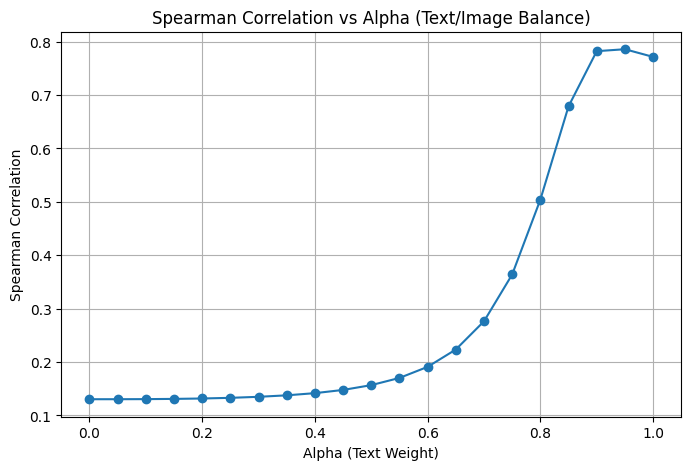

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(alphas, correlations, marker='o')
plt.title("Spearman Correlation vs Alpha (Text/Image Balance)")
plt.xlabel("Alpha (Text Weight)")
plt.ylabel("Spearman Correlation")
plt.grid(True)
plt.show()


Image embeddings work well when:
- Products are visually similar and from the same brand.

- Appearance alone is a strong indicator of match (e.g., identical packaging).